# Predicting Elections using Pandas

#### Setup and Plotting code

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [2]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Here is some code to plot [State Chloropleth](http://en.wikipedia.org/wiki/Choropleth_map) maps in matplotlib. `make_map` is the function you will use.

In [3]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(open("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.loc[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

## Today: the day we make the prediction

In [4]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

## Background: The Electoral College

US Presidential elections revolve around the <a href="http://en.wikipedia.org/wiki/Electoral_College_(United_States)"> Electoral College </a>. In this system, each state receives a number of Electoral College votes depending on it's population -- there are 538 votes in total. In most states, all of the electoral college votes are awarded to the presidential candidate who recieves the most votes in that state. A candidate needs 269 votes to be elected President. 

Thus, to calculate the total number of votes a candidate gets in the election, we add the electoral college votes in the states that he or she wins. (This is not entirely true, with Nebraska and Maine splitting their electoral college votes, but, for the purposes of this homework, we shall assume that the winner of the most votes in Maine and Nebraska gets ALL the electoral college votes there.) 

Here is the electoral vote breakdown by state:

*As a matter of convention, we will index all our dataframes by the state name*

In [5]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


To illustrate the use of `make_map` we plot the Electoral College

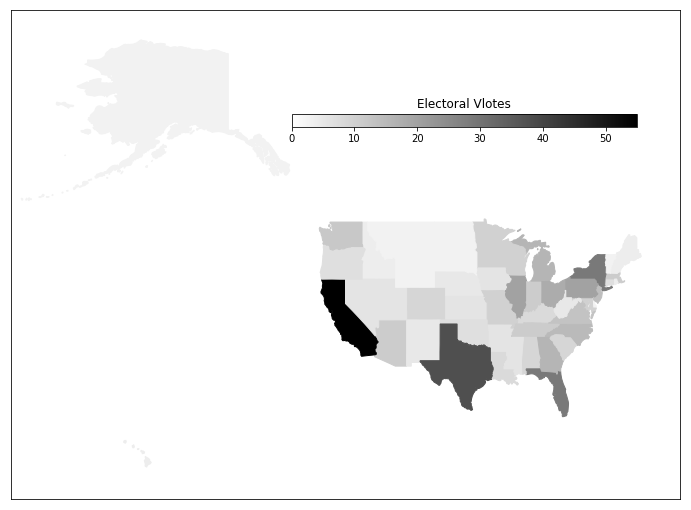

In [6]:
make_map(electoral_votes.Votes, "Electoral Vlotes");

In [7]:
"""
Function
--------
simulate_election

Inputs
------
model : DataFrame
    A DataFrame summarizing an election forecast. The dataframe has 51 rows -- one for each state and DC
    It has the following columns:
       Obama : Forecasted probability that Obama wins the state
       Votes : Electoral votes for the state
    The DataFrame is indexed by state (i.e., model.index is an array of state names)
    
n_sim : int
   Number of simulations to run
   
Returns
-------
results : Numpy array with n_sim elements
   Each element stores the number of electoral college votes Obama wins in each simulation.   
"""

def simulate_election(model, n_sim):
    #each column simulates a single outcome from the 50 states + DC
    #Obama wins the simulation if the random number is < the win probability
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    #summing over rows gives the total electoral votes for each simulation
    return obama_votes.sum(axis=0)

In [8]:
"""
Function
--------
plot_simulation

Inputs
------
simulation: Numpy array with n_sim (see simulate_election) elements
   Each element stores the number of electoral college votes Obama wins in each simulation.
    
Returns
-------
Nothing 
"""


def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(200, 538, 1), 
             label='simulations', align='left', normed=True)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")


To see the usage of this model, lets use probabilities from the betting site predictwise.

In [9]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


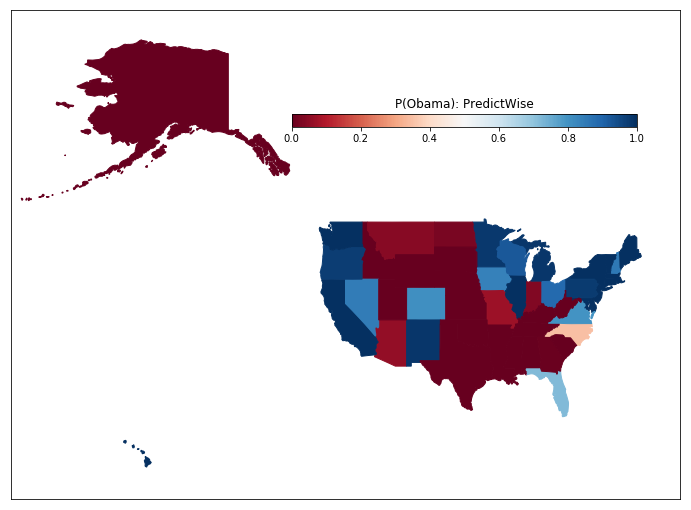

In [10]:
make_map(predictwise.Obama, "P(Obama): PredictWise")

In [11]:
result = simulate_election(predictwise, 10000)
print((result >= 269).mean())

0.9946


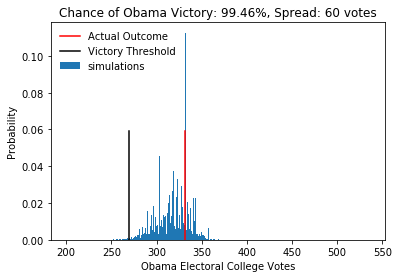

In [12]:
plot_simulation(result)

## Trying to catch Silver: Poll Aggregation

We bring together homogeneous information about the election, by aggregating different polling result together.

This approach -- used by the professional poll analysists -- involves combining many polls about the election itself. One advantage of this approach is that it addresses the problem of bias in individual polls, a problem we found difficult to deal with in problem 1. If we assume that the polls are all attempting to estimate the same quantity, any individual biases should cancel out when averaging many polls (pollsters also try to correct for known biases). This is often a better assumption than assuming constant bias between election cycles, as we did above.

The following table aggregates many of the pre-election polls available as of October 2, 2012. We are most interested in the column "obama_spread". We will clean the data for you:

In [13]:
multipoll = pd.read_csv('data/cleaned-state_data2012.csv', index_col=0)

#convert state abbreviation to full name
multipoll.State.replace(states_abbrev, inplace=True)

#convert dates from strings to date objects, and compute midpoint
multipoll.start_date = multipoll.start_date.apply(pd.to_datetime)
multipoll.end_date = multipoll.end_date.apply(pd.to_datetime)
multipoll['poll_date'] = multipoll.start_date + (multipoll.end_date - multipoll.start_date).values / 2

#compute the poll age relative to Oct 2, in days
multipoll['age_days'] = (today - multipoll['poll_date']).values / np.timedelta64(1, 'D')

#drop any rows with data from after oct 2
multipoll = multipoll[multipoll.age_days > 0]

#drop unneeded columns
multipoll = multipoll.drop(['Date', 'start_date', 'end_date', 'Spread'], axis=1)

#add electoral vote counts
multipoll = multipoll.join(electoral_votes, on='State')

#drop rows with missing data
multipoll.dropna()

multipoll.head()

,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
0,Rasmussen Reports,Washington,4.5,52.0,41.0,500.0,11.0,2012-09-26 00:00:00,6.0,12
1,Gravis Marketing,Washington,4.6,56.0,39.0,625.0,17.0,2012-09-21 12:00:00,10.5,12
2,Elway Poll,Washington,5.0,53.0,36.0,405.0,17.0,2012-09-10 12:00:00,21.5,12
3,SurveyUSA,Washington,4.4,54.0,38.0,524.0,16.0,2012-09-08 00:00:00,24.0,12
4,SurveyUSA,Washington,4.4,54.0,37.0,524.0,17.0,2012-08-01 12:00:00,61.5,12


>YOUR TURN NOW

In [14]:
"""
Function
--------
state_average

Inputs
------
multipoll : DataFrame
   The multipoll data above
   
Returns
-------
averages : DataFrame
  A dataframe, indexed by State, with the following columns:
     N: Number of polls averaged together
     poll_mean: The average value for obama_spread for all polls in this state
     poll_std: The standard deviation of obama_spread
     
Notes
-----
For states where poll_std isn't finite (because N is too small), estimate the
poll_std value as .05 * poll_mean
"""

def state_average(multipoll):
    groups = multipoll.groupby('State')
    n = groups.size()
    mean = groups.obama_spread.mean()
    std = groups.obama_spread.std()
    std[std.isnull()] = .05 * mean[std.isnull()]
    return pd.DataFrame(dict(N=n, poll_mean=mean, poll_std=std))

Lets call the function on the `multipoll` data frame, and outer join it with the `electoral_votes` frame.

In [15]:
avg = state_average(multipoll).join(electoral_votes, how='outer')
avg.head()

,N,poll_mean,poll_std,Votes
State,,,,
Alabama,NaN,NaN,NaN,9
Alaska,NaN,NaN,NaN,3
Arizona,20.0,-5.500000,4.559548,11
Arkansas,3.0,-20.333333,4.041452,6
California,20.0,18.950000,5.548589,55


Some of the reddest and bluest states are not present in this data (people don't bother polling there as much). The `default_missing` function gives them strong Democratic/Republican advantages

In [16]:
def default_missing(results):
    red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Wyoming"]
    blue_states = ["Delaware", "District of Columbia", "Hawaii"]
    results.loc[red_states, ["poll_mean"]] = -100.0
    results.loc[red_states, ["poll_std"]] = 0.1
    results.loc[blue_states, ["poll_mean"]] = 100.0
    results.loc[blue_states, ["poll_std"]] = 0.1
default_missing(avg)
avg.head()

,N,poll_mean,poll_std,Votes
State,,,,
Alabama,NaN,-100.00,0.100000,9
Alaska,NaN,-100.00,0.100000,3
Arizona,20.0,-5.50,4.559548,11
Arkansas,3.0,-100.00,0.100000,6
California,20.0,18.95,5.548589,55


#### Unweighted aggregation

In [17]:
"""
Function
--------
aggregated_poll_model

Inputs
------
polls : DataFrame
   DataFrame indexed by State, with the following columns:
      poll_mean
      poll_std
      Votes

Returns
-------
A DataFrame indexed by State, with the following columns:
   Votes: Electoral votes for that state
   Obama: Estimated probability that Obama wins the state
"""
from scipy.special import erf
def aggregated_poll_model(polls):
    sigma = polls.poll_std
    prob =  .5 * (1 + erf(polls.poll_mean / np.sqrt(2 * sigma ** 2)))
    return pd.DataFrame(dict(Obama=prob, Votes=polls.Votes))

We Run 10,000 simulations with this model, and plot the results. 

>YOUR TURN NOW

//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


(250, 400)

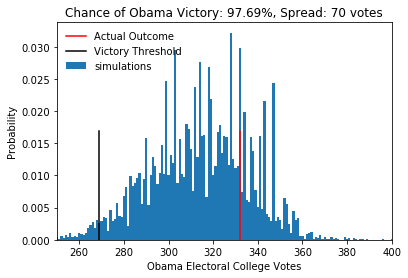

In [18]:
model = aggregated_poll_model(avg)
sims = simulate_election(model, 10000)
plot_simulation(sims)
plt.xlim(250, 400)

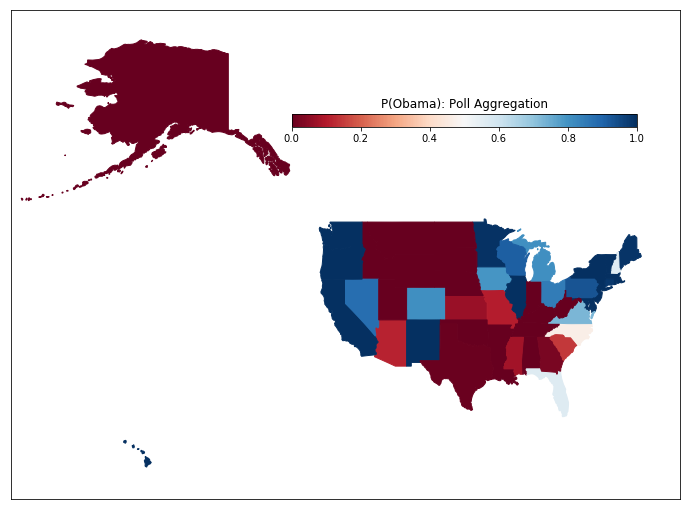

In [19]:
#your code here
make_map(model.Obama, "P(Obama): Poll Aggregation")